<a href="https://colab.research.google.com/github/marco-luzzara/boardgame-complexity-predictor/blob/master/src/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
WORKING_LOCALLY = bool(os.getenv('WORKING_LOCALLY'))

PROCESSED_DATASET_FILE_PATH = 'data/processed_dataset.csv' if WORKING_LOCALLY \
    else '/content/drive/My Drive/Projects/IRBoardGameComplexity/processed_dataset.csv'

if not WORKING_LOCALLY:
    from google.colab import drive
    drive.mount('/content/drive')

df_features = pd.read_csv(PROCESSED_DATASET_FILE_PATH)
df_features.head()

Mounted at /content/drive


,averageweight,playingtime,rulebook_len,dice_luck_metric,drawing_luck_metric,shuffling_luck_metric,random_luck_metric,can_metric,choices_metric,entities_count,...,entities_variance,abstracts,cgs,childrensgames,familygames,partygames,strategygames,thematic,unspecified,wargames
0,2.1579,60,3155.0,0.0,0.000000,0.147710,0.000000,0.590842,0.295421,5.0,...,2.439704,0,0,0,1,0,0,0,0,0
1,3.1452,90,73093.0,0.0,0.013557,0.027113,0.027113,1.342100,0.135566,62.0,...,47.504669,0,0,0,0,0,1,0,0,0
2,1.8100,90,20155.0,0.0,0.000000,0.000000,0.000000,0.911927,0.143988,39.0,...,13.679672,0,0,0,0,0,0,1,0,0
3,1.4858,30,13866.0,0.0,0.413936,0.137979,0.000000,0.551914,0.275957,14.0,...,9.450702,0,0,0,1,0,0,0,0,0
4,2.7813,120,3604.0,0.0,0.000000,0.000000,0.000000,0.583090,1.020408,8.0,...,1.764098,0,0,0,0,0,1,0,0,0


In [4]:
from collections import namedtuple
from typing import Generator, Tuple, List
from sklearn.model_selection import KFold

FeaturesWithPrediction = namedtuple('FeaturesWithPrediction', ['y', 'x'])
SplitDataset = namedtuple('SplitDataset', ['train', 'test'])

def get_actual_value(dataset: pd.DataFrame) -> pd.DataFrame:
    return dataset.iloc[:, 0]

def get_features(dataset: pd.DataFrame) -> pd.DataFrame:
    return dataset.iloc[:, 1:]

def get_train_test_from_cv(kfold: KFold, dataset: pd.DataFrame) \
    -> Generator[SplitDataset, None, None]:
    '''generate K groups of train and test set from CV ((train_y, train_x), (test_y, test_x))'''
    for train_indices, test_indices in kfold.split(dataset):
        train = dataset.iloc[train_indices]
        test = dataset.iloc[test_indices]
        yield SplitDataset(\
                           FeaturesWithPrediction(get_actual_value(train), get_features(train)),
                           FeaturesWithPrediction(get_actual_value(test), get_features(test))
                           )

class Model:
    def __init__(self, instance, params_tuning = None):
        self.instance = instance
        self.name = instance.__class__.__name__
        self.params_tuning = params_tuning

In [3]:
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from typing import List

MIN_COMPLEXITY, MAX_COMPLEXITY = 0, 5
MAX_PLOT_IN_ROW = 3
PLOT_INCHES = 6

def decorate_subplot(index: int, ax, i_model: int, title: str, y_test, predictions) -> None:
    row = i_model // MAX_PLOT_IN_ROW
    col = i_model % MAX_PLOT_IN_ROW
    subplot = ax[row][col]
    subplot.set_title(title)
    subplot.axis([MIN_COMPLEXITY, MAX_COMPLEXITY, MIN_COMPLEXITY, MAX_COMPLEXITY])
    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Actual')
    subplot.grid(True)
    subplot.plot(predictions, y_test, 'ro', [MIN_COMPLEXITY, MAX_COMPLEXITY], [MIN_COMPLEXITY, MAX_COMPLEXITY])

def create_containing_plot(plot_id: int, models: List[Model]): 
    num_models = len(models)
    containing_plot_rows = math.ceil(num_models / MAX_PLOT_IN_ROW)
    containing_plot_height = containing_plot_rows * PLOT_INCHES
    fig, ax = plt.subplots(nrows=containing_plot_rows, ncols=MAX_PLOT_IN_ROW, squeeze=False,
                           figsize=(MAX_PLOT_IN_ROW * PLOT_INCHES, containing_plot_rows * PLOT_INCHES), 
                           num=plot_id)
    for i in range(containing_plot_rows * MAX_PLOT_IN_ROW - num_models):
        fig.delaxes(ax[-1][MAX_PLOT_IN_ROW - i - 1])
    
    return fig, ax

def create_header(text: str):
    display(widgets.HTML(
        value=f"<h1>{text}</h1>"
    ))

,Model,R2,MAE,MAPE,MSE
0,LinearRegression,0.553298,0.379189,0.189870,0.249027
0,LassoCV,0.093410,0.540407,0.277965,0.505405
0,ElasticNetCV,0.093357,0.540471,0.278004,0.505434
0,RidgeCV,0.567552,0.371680,0.185402,0.241081
0,BayesianRidge,0.572957,0.368983,0.183877,0.238067


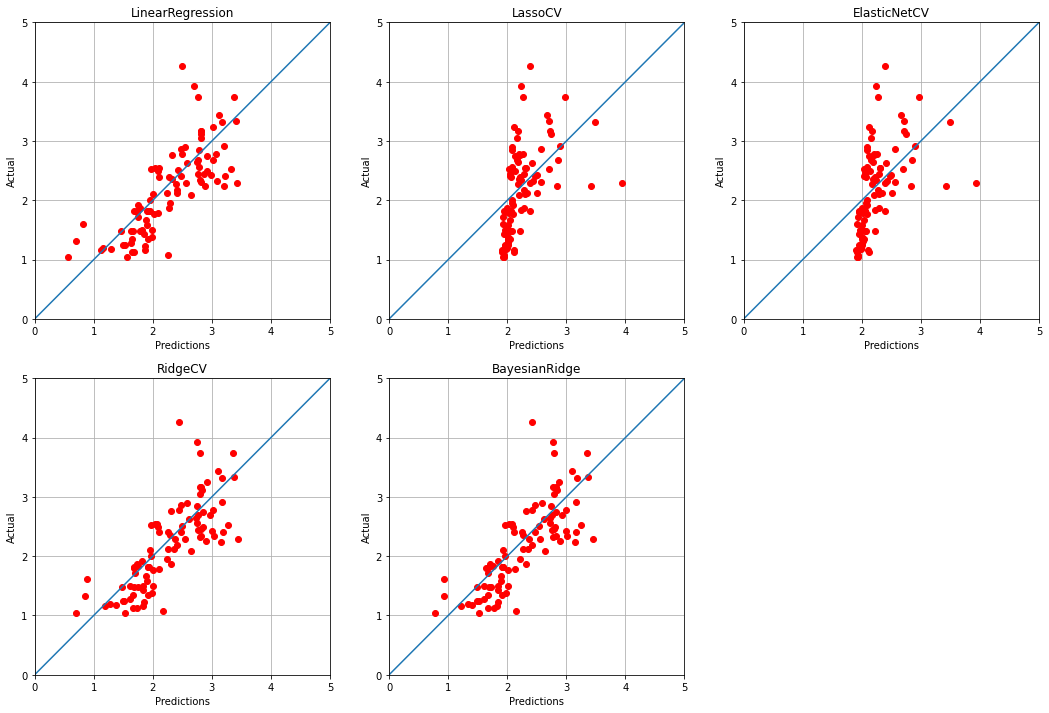

In [10]:
import numpy as np
from sklearn import linear_model, svm, kernel_ridge, neighbors, \
    gaussian_process, cross_decomposition, tree
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy import stats

models = {
    'Linear Models': [
        Model(linear_model.LinearRegression()),
        Model(linear_model.LassoCV()),
        Model(linear_model.ElasticNetCV()),
        Model(linear_model.RidgeCV()),
        Model(linear_model.BayesianRidge(), {
            'alpha_1': stats.gamma.rvs(1, size = 5), 'alpha_2': stats.gamma.rvs(1, size = 5), 
            'lambda_1': stats.gamma.rvs(1, size = 5), 'lambda_2': stats.gamma.rvs(1, size = 5), 
        }),
        # Model(linear_model.HuberRegressor()),
        # Model(linear_model.TweedieRegressor()),
        # Model(linear_model.QuantileRegressor())
    ],
    # 'Support Vector Machines': [Model(svm.SVR())],
    # 'Kernel Ridge': [Model(kernel_ridge.KernelRidge())],
    # 'Nearest Neighbors': [
    #     Model(neighbors.KNeighborsRegressor(weights='uniform')),
    #     Model(neighbors.KNeighborsRegressor(weights='distance'))
    # ],
    # 'Gaussian Process': [
    #     Model(gaussian_process.GaussianProcessRegressor())
    # ],
    # 'Cross Decomposition': [
    #     Model(cross_decomposition.PLSCanonical()),
    #     Model(cross_decomposition.PLSRegression()),
    #     Model(cross_decomposition.CCA()),
    # ],
    # # TODO: see ensemble methods
    # 'Decision Tree': [
    #     Model(tree.DecisionTreeRegressor()),
    #     Model(tree.ExtraTreeRegressor()),
    # ]
}

results = pd.DataFrame(columns=['Model', 'R2', 'MAE', 'MAPE', 'MSE'])
cv_scorings = ['r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(df_features.iloc[:, 1:], 
                                                    df_features.iloc[:, 0],
                                                    test_size=0.25)

for i_category, item in enumerate(models.items()):
    #create_header(item[0])
    fig, ax = create_containing_plot(i_category, item[1])
    for i_m, model in enumerate(item[1]):
        
        if model.params_tuning is None:
            estimator = model.instance
            estimator.fit(X_train, y_train)
        else:
            search = GridSearchCV(model.instance, 
                                model.params_tuning,
                                cv = splitter,
                                refit = 'neg_mean_absolute_error',
                                n_jobs = -1, 
                                scoring = cv_scorings)
            
            search.fit(X_train, y_train)
            estimator = search.best_estimator_
            #display(pd.DataFrame(search.cv_results_))

        y_predictions = estimator.predict(X_test)
        
        r2 = r2_score(y_test, y_predictions) # np.mean(cv_results['test_r2'])
        mae = mean_absolute_error(y_test, y_predictions) # np.mean(cv_results['test_neg_mean_absolute_error'])
        mape = mean_absolute_percentage_error(y_test, y_predictions) # np.mean(cv_results['test_neg_mean_absolute_percentage_error'])
        mse = mean_squared_error(y_test, y_predictions) # np.mean(cv_results['test_neg_mean_squared_error'])

        results = pd.concat([results, pd.DataFrame([
            { 
                'Model': model.name, 
                'R2': r2, 
                'MAE': mae, 
                'MAPE': mape,
                'MSE': mse
            }
            ])])
        decorate_subplot(i_category, ax, i_m, model.name, y_test, y_predictions)

results